In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Link to kaggle notebook

https://www.kaggle.com/code/shubhammisar/nyc-taxi-time-series-lstm

## Data Preparation

In [3]:
df = pd.read_csv('dataset.csv', index_col=0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 241.9+ KB


In [5]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [6]:
# Converting to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
# Setting a datetime index to the dataframe
df = df.set_index('timestamp')

In [8]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [9]:
# Checking NULL values
df.isna().sum()

value    0
dtype: int64

No null values present in our data 

## Visualizing the data

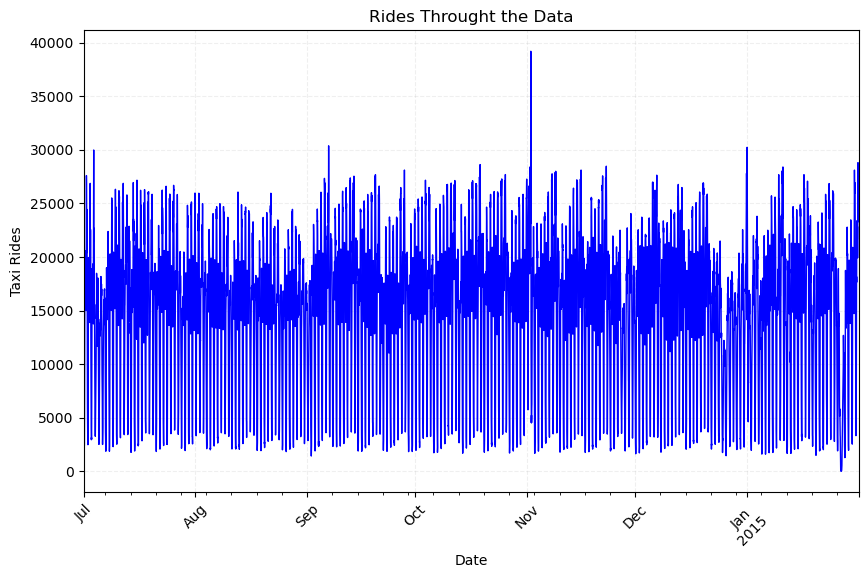

In [10]:
df['value'].plot(figsize=(10, 6), color='blue', linewidth=1)


plt.xlabel('Date')
plt.ylabel('Taxi Rides')
plt.title('Rides Throught the Data')


plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.2)

plt.show()


Let's see about the peak we get

In [11]:
df[df['value'] > 35000]

,value
timestamp,
2014-11-02 01:00:00,39197
2014-11-02 01:30:00,35212


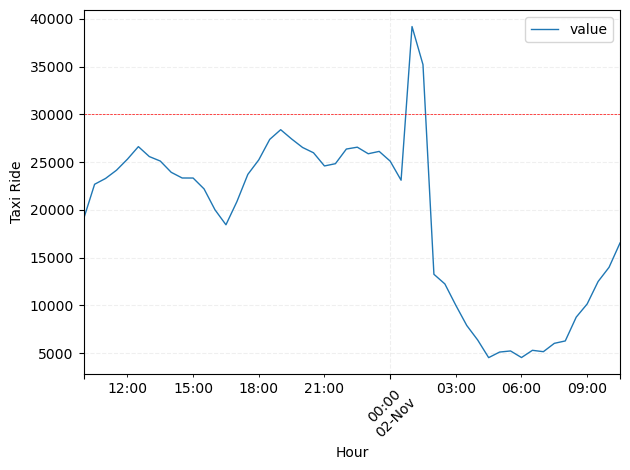

In [12]:
# Taking a closure look at the data

df.loc['2014-11-01 10:00:00':,].head(50).plot(linewidth = 1)

plt.xlabel('Hour')
plt.ylabel('Taxi Ride')
plt.xticks(rotation = 45)
plt.axhline(y = 30000, color = 'red', linestyle = '--', linewidth = 0.5)
plt.tight_layout()
plt.grid(linestyle = '--', alpha = 0.2)
plt.show()

We see something happened on 2 nov 2014 at 1am since there is a high volumne of rides during that hour

In [13]:
# Capping these outlier to 20000
df[df['value'] > 35000] = 20000

Let's add other time attributes to better visualize the data

In [14]:
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df.head()

,value,day,hour,weekday,month
timestamp,,,,,
2014-07-01 00:00:00,10844,1,0,1,7
2014-07-01 00:30:00,8127,1,0,1,7
2014-07-01 01:00:00,6210,1,1,1,7
2014-07-01 01:30:00,4656,1,1,1,7
2014-07-01 02:00:00,3820,1,2,1,7


Lets resample to downsample our data to number days and plot

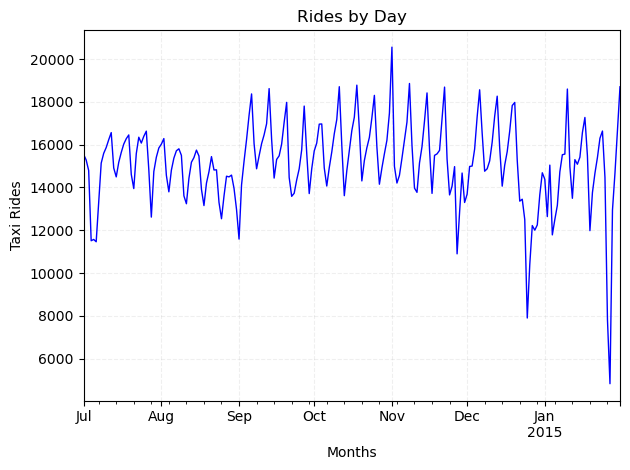

In [15]:
df_day = df['value'].resample('D').mean()
df_day.plot(linewidth = 1, color = 'blue')
plt.xlabel("Months")
plt.ylabel("Taxi Rides")
plt.title("Rides by Day")
plt.tight_layout()
plt.grid(linestyle = '--', alpha = 0.2)
plt.show()

The data displays a seasonal pattern, with two evident changepoints.
1. The first changepoint occurs in early September
2. The second occurs at the end of December.

The seasonal trend suggests an increase in taxi rides after August, potentially due to the winter season, while higher variance in January may be influenced by daily weather conditions.

Lets see Data across each month and day

In [16]:
df

,value,day,hour,weekday,month
timestamp,,,,,
2014-07-01 00:00:00,10844,1,0,1,7
2014-07-01 00:30:00,8127,1,0,1,7
2014-07-01 01:00:00,6210,1,1,1,7
2014-07-01 01:30:00,4656,1,1,1,7
2014-07-01 02:00:00,3820,1,2,1,7
...,...,...,...,...,...
2015-01-31 21:30:00,24670,31,21,5,1
2015-01-31 22:00:00,25721,31,22,5,1
2015-01-31 22:30:00,27309,31,22,5,1


In [17]:
import calendar

In [18]:
calendar.month_name[3]

'March'

In [19]:
df["month"] = df["month"].apply(lambda x: calendar.month_name[x])

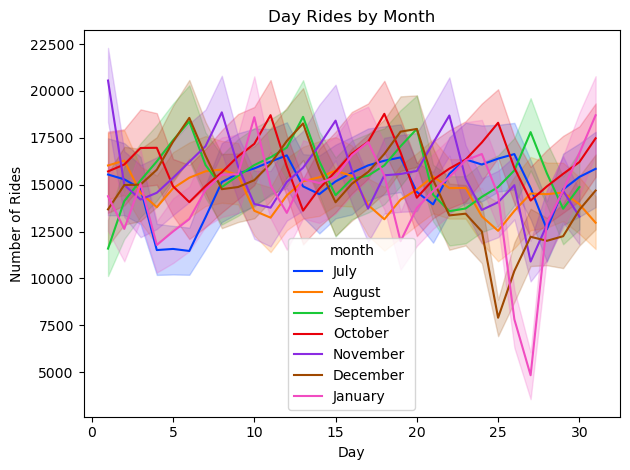

In [20]:
sns.lineplot(
    x="day", 
    y="value",
    data=df,
    palette='bright',
    
    hue= "month")
plt.xlabel("Day")
plt.ylabel("Number of Rides")
plt.title("Day Rides by Month")
plt.tight_layout()
plt.show()


In [21]:
df['weekday'] = df['weekday'].apply(lambda x: calendar.day_name[x])

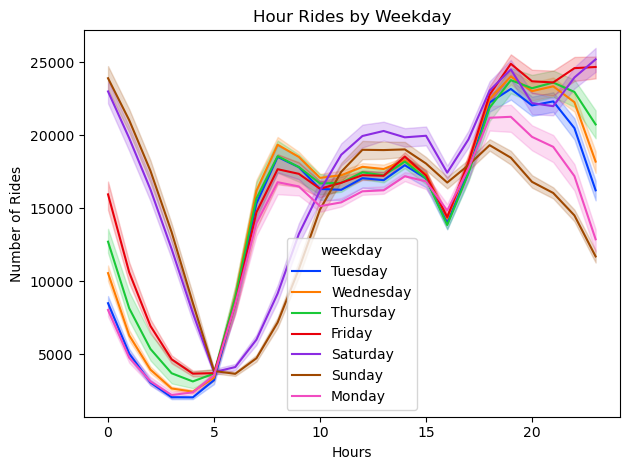

In [22]:

sns.lineplot(
    x="hour", 
    y="value",
    data=df,
    palette='bright',
    hue= "weekday")
plt.xlabel("Hours")
plt.ylabel("Number of Rides")
plt.title("Hour Rides by Weekday")
plt.tight_layout()
plt.show()


In [23]:
df = df.resample('D').mean()


C:\Users\shubh\AppData\Local\Temp\ipykernel_20336\186644445.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('D').mean()


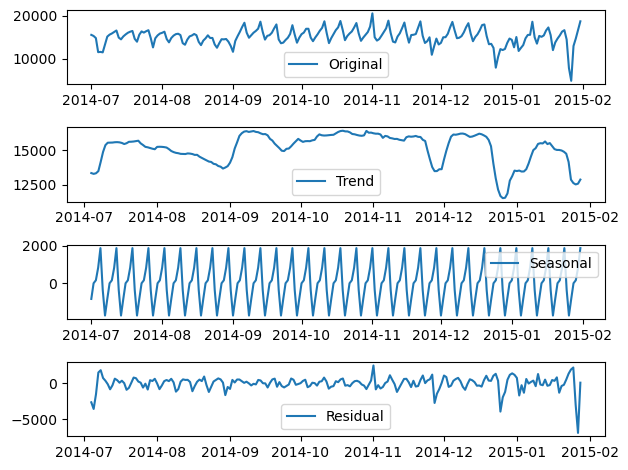

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposed = seasonal_decompose(df["value"], model = 'additive')


# Access the individual components
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot the original time series
plt.subplot(411)
plt.plot(df["value"], label='Original')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


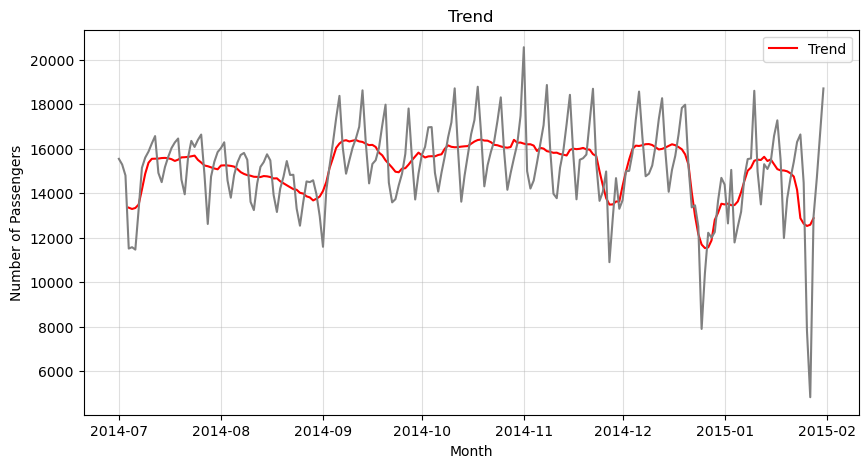

In [25]:
# Plot the seasonally adjusted trend
plt.figure(figsize=(10, 5))
plt.plot(trend, color = 'red', label = 'Trend')
plt.plot(df.index, df['value'], color='gray')
plt.ylabel('Number of Passengers')
plt.xlabel('Month')
plt.title('Trend')
plt.grid(alpha = 0.4)
plt.legend()
plt.show()

## Examining Properties

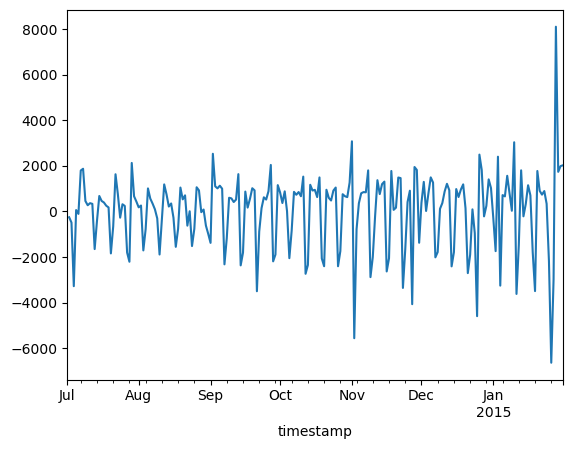

In [26]:
df['value'].diff().plot()
plt.show()

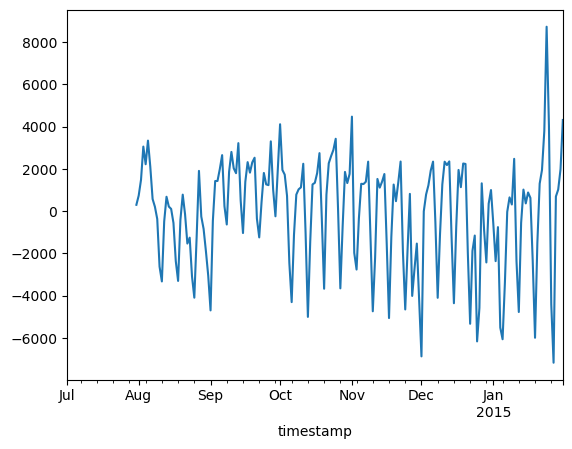

In [27]:
df['value'].diff(30).plot()
plt.show()

In [28]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(df['value'].diff(30)[30:])

# Extract and print the test statistic
print('Test Statistic:', result[0])

# Extract and print the p-value
print('p-value:', result[1])


Test Statistic: -3.2315186934405573
p-value: 0.01823122331214966


Not Stationary

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


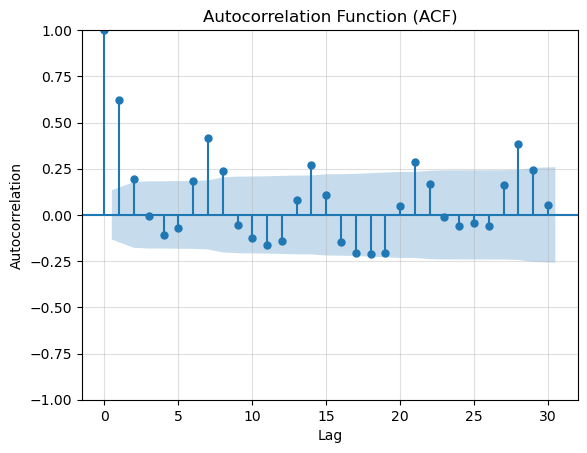

In [30]:
data = df['value']

plot_acf(data, lags=30)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(alpha = 0.4)
plt.show()


c:\Users\shubh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


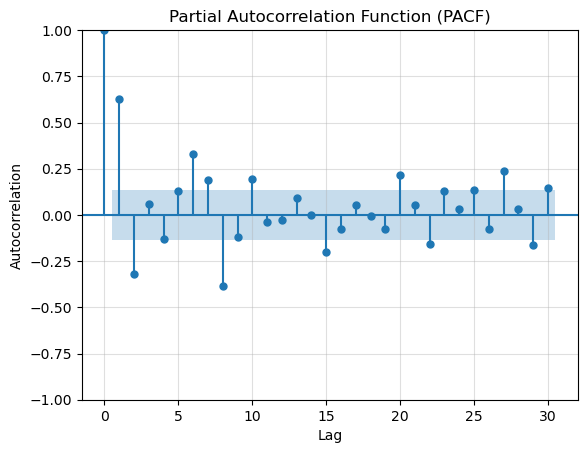

In [31]:
data = df['value']

plot_pacf(data, lags=30)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(alpha = 0.4)
plt.show()


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2014-07-01 to 2015-01-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   215 non-null    float64
 1   day     215 non-null    float64
 2   hour    215 non-null    float64
dtypes: float64(3)
memory usage: 6.7 KB


## Modelling

In [33]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

values = df['value'].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values.reshape(-1,1))


In [34]:
train_size = int(len(scaled_values) * 0.8)
train_data = scaled_values[:train_size]
test_data = scaled_values[train_size:]


In [35]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)


In [36]:
sequence_length = 10  
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [38]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [39]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test)

# Print the predicted and actual values
for i in range(len(predicted_values)):
    print('Predicted:', predicted_values[i], 'Actual:', actual_values[i])

Epoch 1/50
6/6 [==============================] - 1s 6ms/step - loss: 0.5532
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 0.4232
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 0.3072
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 0.1957
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0901
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 7/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0258
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 10/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 11/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 12/50
6/6 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 13/50
6/6 [==============================] - 0s 5ms/step - loss: 0.

## Forecasting

6/6 [==============================] - 0s 4ms/step


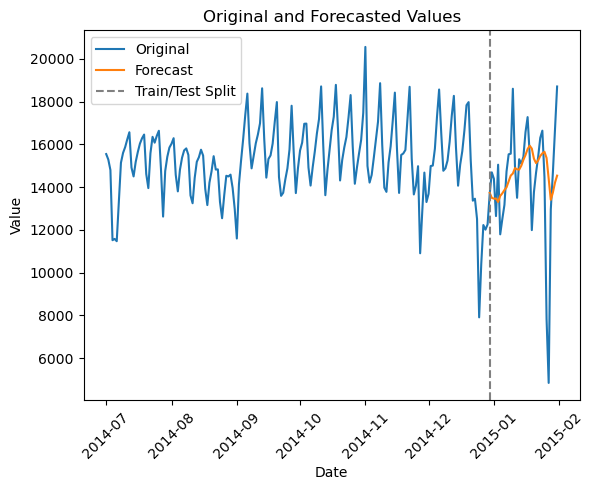

In [62]:
import matplotlib.pyplot as plt

# Plotting the original values
plt.plot(data, label='Original')
#plt.plot(data.index[-len(predicted_values):], label = "Original Test")
# Plotting the forecasted values

predictions = model.predict(X_train)

plt.plot(data.index[-len(predicted_values):], predicted_values, label='Forecast')
plt.axvline(data.index[-len(predicted_values)], color='grey', linestyle='--', label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original and Forecasted Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()
